In [71]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import random
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
pd.set_option('display.max_columns', 100)  # or 1000
pd.set_option('display.max_rows', 100)  # or 1000
import time
from numpy import concatenate
Scaler = MinMaxScaler()
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout

In [2]:
# Load testing dataset(Daily data)
def read_daily_df(test_time,features,file): # test_time = pd.Timestamp(yyyy,mm,dd)
    Lake_HydMet = pd.read_csv(file,header = 0,sep = '\t',parse_dates = ['Date'])
    Lake_HydMet = Lake_HydMet[features]
    return Lake_HydMet

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in, n_out, var_name,dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1] # number of variables
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(var_name[j]+'(t-%d)' % (i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(var_name[j]+'(t)') for j in range(n_vars)]
        else:
            names += [(var_name[j]+'(t+%d)' % (i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

In [4]:
# load dataset
def load_dataset(df,var_name):
    values = df[var_name].values
    return values

In [5]:
# reframe dataset
def reframe(values,hyperparameters,var_names):
    reframed = series_to_supervised(values, hyperparameters['time_steps'], hyperparameters['n_out'],var_names)
    reframed = reframed.iloc[hyperparameters['time_steps']:]
    drop_col =[]
    n_var = len(var_names)
    for i in range(1,hyperparameters['time_steps']+1):
        drop_col += [n_var*i-1]
    reframed.drop(reframed.iloc[:,drop_col],axis=1,inplace = True)
    return reframed

In [6]:
def sparse_dataset(data_X,data_y):
    index = []
    y = []
    for i in range(len(data_y)):
        if ~np.isnan(data_y[i]):
            index.append(i)
            y.append(data_y[i])
    X = np.stack(data_X[index,:,:])
    y = np.array(y)
    return index,X,y

In [7]:
def fit_lstm(train_X,train_y,n_batch,nb_epoch,n_neuros,dropout,verbose):
    # design network
    model = Sequential()
    model.add(LSTM(n_neuros,  return_sequences = True,
              input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(dropout))
    model.add(LSTM(n_neuros, return_sequences = True))
    model.add(Dropout(dropout))
    model.add(LSTM(n_neuros))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_X,train_y,epochs =nb_epoch,batch_size = n_batch,verbose = verbose)
    return model

In [8]:
def plot_comparison(df,y,yhat,yhat_ts,n_date,time_steps,index,rmse,r2,nutrient,test_time,ylim):
    # Observation time
    time = df['Date'].iloc[n_date+time_steps:].reset_index()['Date'].iloc[index] 
    # Direct comparison of observation and prediction [yhat] (data point to data point)
    pred = pd.DataFrame(concatenate((yhat.reshape(yhat.shape[0],1),y.reshape(y.shape[0],1)), axis=1),
                        index = time)
    pred.columns = ['Prediction','True value']
    # Extract the continuous timeseries from input dataset
    time_ts = df['Date'].iloc[n_date+time_steps:]
    # The continuous prediction yhat_ts 
    pred_ts = pd.DataFrame(yhat_ts,index = time_ts,columns = ['Prediction'])
    # Compute the 7d rolling mean of the timeseries predction
    pred_ts['Prediction_7d'] = pred_ts['Prediction'].rolling(7,min_periods = 1).mean()
    # Create a continous timeseries without winter gap
    Date = pd.DataFrame(pd.date_range(start = time_ts.iloc[0],
                                  end = time_ts.iloc[-1]),
                    columns = ['Date'])
    pred_ts_gap = Date.merge(pred_ts,how = 'left',on = 'Date')
    f1,ax1 = plt.subplots(1,2,figsize = (18,6),gridspec_kw={'width_ratios': [2, 1]})
    pred_ts_gap.plot(x = 'Date',y = ['Prediction','Prediction_7d'],
                     style = {'Prediction':'b-','Prediction_7d':'k-'},
                     ax = ax1[0])
    pred.plot(y = 'True value',style='ro',alpha = 0.7,ms = 7,ax = ax1[0])
    ax1[0].set_ylabel(nutrient)
    ax1[0].set_xlim((test_time[0],test_time[1]))
    ax1[0].set_ylim(ylim)
    ax1[0].text(0.7, 0.9, 'RMSE:{}'.format(round(rmse,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax1[0].transAxes,fontsize='x-large')
    pred.plot(x = 'True value', y = 'Prediction',kind = 'scatter',s = 20,c = 'blue',ax = ax1[1])
    ax1[1].plot(pred['True value'],pred['True value'],lw  =1.5,color = 'black')
    ax1[1].text(0.5, 0.8, 'R2:{}'.format(round(r2,2)), 
                horizontalalignment='center',verticalalignment='center', 
                transform=ax1[1].transAxes,fontsize='x-large')
    return f1

In [9]:
def predict_ts(df,nutrient,model,hyperparameters,values):
    # add the predictive values into dataset
    value_X, value_y = values[:, :-1], values[:, -1]
    value_X = value_X.reshape((value_X.shape[0], hyperparameters['time_steps']+1, int(value_X.shape[1]/(hyperparameters['time_steps']+1))))
    y_pred = Scaler.inverse_transform(model.predict(value_X,batch_size = hyperparameters['n_batch']))    
    df[nutrient].iloc[hyperparameters['time_steps']:]=y_pred[:,0]
    df[nutrient].fillna(method = 'backfill',inplace = True)
    return df

In [10]:
def split_dataset(train,test,time_steps):
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], time_steps+1, int(train_X.shape[1]/(time_steps+1))))
    test_X = test_X.reshape((test_X.shape[0], time_steps+1, int(test_X.shape[1]/(time_steps+1))))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    print('number of input timesteps: {}'.format(train_X.shape[1]))
    print('number of features: {}'.format(train_X.shape[2]))
    return train_X, train_y,test_X, test_y

In [11]:
# ensure all data is float
def predict_lstm(df,values,var_name,nutrient,test_time,hyperparameters,ylim):
    n_date = df[df['Date']<test_time[0]]['Date'].count()
    train = values[:n_date, :]
    test = values[n_date:, :]
    train_X, train_y,test_X, test_y = split_dataset(train,test,hyperparameters['time_steps'])
    # fit the lstm model
    index,X,y = sparse_dataset(train_X,train_y) # stack the timeseries input together to create a 2D training input X, and a 1D lable y
    y_scaled = Scaler.fit_transform(y.reshape(-1,1))
    print('number of samples: {}'.format(len(index)))
    kf = KFold(n_splits=5, shuffle=True, random_state=101) # 5-fold cross validation
    RMSE = []
    R2 = []
    # fit the lstm model 
    for train_index, test_index in kf.split(X,y_scaled):
        #print("TRAIN:", len(train_index), "TEST:", len(test_index))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y_scaled[train_index], y_scaled[test_index]
        model = fit_lstm(X_train,y_train,hyperparameters['n_batch'],hyperparameters['nb_epoch'],
                         hyperparameters['n_neuros'],hyperparameters['dropout'],hyperparameters['verbose'])
        yhat = Scaler.inverse_transform(model.predict(X_test,batch_size = hyperparameters['n_batch']))
        y_test = Scaler.inverse_transform(y_test)
        rmse = sqrt(mean_squared_error(y_test, yhat))
        r2 =  r2_score(y_test, yhat)
        RMSE.append(rmse) 
        R2.append(r2)
        #print('Training RMSE: %.2f' %rmse)       
    # make a prediction
    model = fit_lstm(X,y_scaled,hyperparameters['n_batch'],hyperparameters['nb_epoch'],
                     hyperparameters['n_neuros'],hyperparameters['dropout'],hyperparameters['verbose'])
    index,X,y = sparse_dataset(test_X,test_y) # index is the time series
    yhat = Scaler.inverse_transform(model.predict(X,batch_size = hyperparameters['n_batch']))
    rmse = sqrt(mean_squared_error(y, yhat))
    r2 = r2_score(y, yhat)
    print('Test RMSE: %.2f' % rmse)
    print('Test R2: %.2f' %r2)
    # make a prediction for the whole timeseries
    yhat_ts = Scaler.inverse_transform(model.predict(test_X,batch_size = hyperparameters['n_batch']))
    figure = plot_comparison(df,y,yhat,yhat_ts,n_date,hyperparameters['time_steps'],index,rmse,r2,nutrient,test_time,ylim)
    return model,RMSE,R2,figure

In [72]:
## Load training dataset
# Make sure you are in the main folder('..\Algal-bloom-prediction-machine-learning')
cd = os.getcwd()
while cd.split('\\')[-1]!='Algal-bloom-prediction-machine-learning':
    os.chdir('..')
    cd=os.getcwd()
    
os.chdir('Trainning data')
print('Load training data (containing nutrient observations)')
lakename = input('Lake name in short:')
winter = input('Winter data or not? (Y/N)')
if winter =='Y':
    all_df = pd.read_csv(lakename+'_Observation_df.csv',sep = '\t',parse_dates = ['Date'])
else:
    all_df = pd.read_csv(lakename+'_Observation_df_nowinter.csv',sep = '\t',parse_dates = ['Date'])

Load training data (containing nutrient observations)
Lake name in short:ME
Winter data or not? (Y/N)N


In [74]:
# Create the daily df with Nan in nutrients columns'
print(all_df.info())
n_Nut = int(input('Number of nutrients: (including Chl)'))
Nut_f = ['Date']
for i in range(n_Nut):
    f = input('Nutrients: ')
    Nut_f.append(f)
print(Nut_f)
Nut = all_df[Nut_f]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              199 non-null    datetime64[ns]
 1   O2                199 non-null    float64       
 2   CAR_dic           199 non-null    float64       
 3   Si                199 non-null    float64       
 4   N_Nit             199 non-null    float64       
 5   PO4               199 non-null    float64       
 6   N_Amm             199 non-null    float64       
 7   Chl               199 non-null    float64       
 8   SST               199 non-null    float64       
 9   delT              199 non-null    float64       
 10  U                 199 non-null    float64       
 11  AirT              199 non-null    float64       
 12  Prec              199 non-null    float64       
 13  swr               199 non-null    float64       
 14  MLD               199 non-

In [126]:
n_feature = int(input('Number of features used for basic training: '))
features = ['Date']
for i in range(n_feature):
    f = input('Feature:')
    features.append(f)
print(features)

Number of features used for basic training: 11
Feature:delT
Feature:U
Feature:AirT
Feature:Prec
Feature:swr
Feature:MLD
Feature:W
Feature:Ice_d
Feature:days_from_iceoff
Feature:inflow
Feature:outflow
['Date', 'delT', 'U', 'AirT', 'Prec', 'swr', 'MLD', 'W', 'Ice_d', 'days_from_iceoff', 'inflow', 'outflow']


In [76]:
# date to seperate training and test sets
YY=all_df['Date'].apply(lambda d:d.year).unique()
print(YY)
test_time = [pd.Timestamp(int(input('test starts in year:')),1,1),pd.Timestamp(int(input('test ends in year:')),1,1)]

[1999 2000 2001 2002 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015]
test starts in year:2012
test ends in year:2016


In [77]:
# Read daily observation data
if winter =='Y':
    file = lakename+'_Daily_Observation_df.csv'
else:
    file = lakename+'_Daily_Observation_df_nowinter.csv'
Daily_df = read_daily_df(test_time,features,file) 

In [83]:
# set the hyperparameters
hyperparameters = {'n_batch':10,'nb_epoch':100,'n_neuros':200,'dropout':0.1,'time_steps':7,'n_out':1,'verbose':0}

In [84]:
# Change to the LSTM folder
# Make sure you are in the main folder('..\Algal-bloom-prediction-machine-learning')
cd = os.getcwd()
while cd.split('\\')[-1]!='Algal-bloom-prediction-machine-learning':
    os.chdir('..')
    cd=os.getcwd()
os.chdir('Scenario2\\LSTM')

Nutrient: O2
(9075, 8, 11) (9075,) (1093, 8, 11) (1093,)
number of input timesteps: 8
number of features: 11
number of samples: 73
Test RMSE: 34.71
Test R2: 0.75
Training dataset RMSE 41.63 (+/- 5.51)
Training dataset R2 0.60 (+/- 0.09)
Model takes 4 min to run


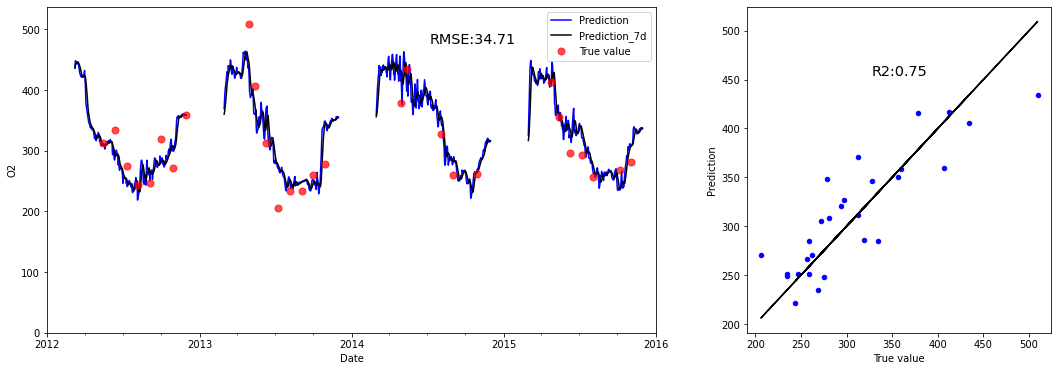

In [127]:
# predict nutreint 1
nutrient = input('Nutrient: ')
# If add the features from process-based model, add features 'MLD','W','thermD'
features.pop(0) # Remove 'Date'
features.append(nutrient)
Nut_memory = Daily_df.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                            how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values
ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [128]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,SST,delT,U,AirT,Prec,swr,MLD,W,Ice_d,days_from_iceoff,inflow,outflow,O2
0,1979-03-01,0.764389,-2.620929,1.593941,-2.992495,0.4762,185.210999,1.548121,0.000000,93.000000,-46,7.635921,7.867276,434.914856
1,1979-03-02,0.920434,-2.468256,4.249354,-5.280408,0.6036,188.470290,1.501116,0.000000,93.000000,-45,7.287510,7.936561,434.914856
2,1979-03-03,0.727219,-2.664457,3.202813,-1.517493,9.6772,75.183791,0.650000,0.000000,93.000000,-44,8.554949,8.209879,434.914856
3,1979-03-04,0.174805,-3.218732,1.919469,0.616671,3.0956,109.187751,0.650000,0.000000,93.000000,-43,9.942403,8.346746,434.914856
4,1979-03-05,0.084467,-3.311187,2.815478,-2.330826,0.0822,84.293958,0.650000,0.000000,93.000000,-42,9.816358,8.669169,434.914856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10170,2015-11-26,6.730435,0.778029,3.169159,4.285010,25.0532,25.239375,25.000000,0.000000,100.958333,223,16.804982,11.418577,337.377838
10171,2015-11-27,6.626987,0.000000,5.685337,2.327086,12.5068,66.596083,25.000000,0.000000,100.958333,224,15.235910,13.823858,338.115784
10172,2015-11-28,6.360925,1.181410,2.800493,-0.982494,0.0000,81.125292,23.150000,1.769155,100.958333,225,17.910961,14.750084,337.865784
10173,2015-11-29,6.137963,1.383737,1.984414,-1.319994,0.0000,42.381708,21.874141,2.731964,100.958333,226,18.948644,15.256056,337.856110


Nutrient: N_Nit
['delT', 'U', 'AirT', 'Prec', 'swr', 'MLD', 'W', 'Ice_d', 'days_from_iceoff', 'inflow', 'outflow', 'O2']
Delete features? (Y/N)N
Add features? (Y/N)N
(9075, 8, 12) (9075,) (1093, 8, 12) (1093,)
number of input timesteps: 8
number of features: 12
number of samples: 73
Test RMSE: 14.43
Test R2: 0.43
Training dataset RMSE 15.47 (+/- 2.74)
Training dataset R2 0.63 (+/- 0.12)
Model takes 4 min to run


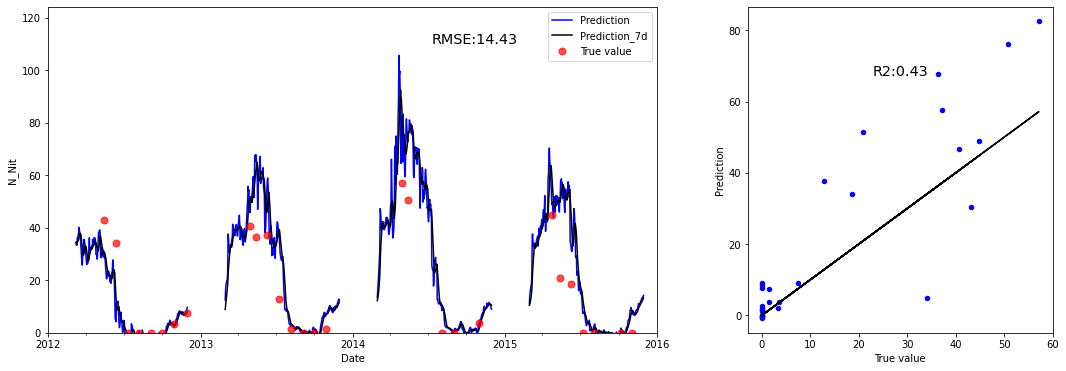

In [129]:
# predict nutreint 2
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 

features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates()
                              ,how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [130]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,SST,delT,U,AirT,Prec,swr,MLD,W,Ice_d,days_from_iceoff,inflow,outflow,O2,N_Nit
0,1979-03-01,0.764389,-2.620929,1.593941,-2.992495,0.4762,185.210999,1.548121,0.000000,93.000000,-46,7.635921,7.867276,434.914856,36.579849
1,1979-03-02,0.920434,-2.468256,4.249354,-5.280408,0.6036,188.470290,1.501116,0.000000,93.000000,-45,7.287510,7.936561,434.914856,36.579849
2,1979-03-03,0.727219,-2.664457,3.202813,-1.517493,9.6772,75.183791,0.650000,0.000000,93.000000,-44,8.554949,8.209879,434.914856,36.579849
3,1979-03-04,0.174805,-3.218732,1.919469,0.616671,3.0956,109.187751,0.650000,0.000000,93.000000,-43,9.942403,8.346746,434.914856,36.579849
4,1979-03-05,0.084467,-3.311187,2.815478,-2.330826,0.0822,84.293958,0.650000,0.000000,93.000000,-42,9.816358,8.669169,434.914856,36.579849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10170,2015-11-26,6.730435,0.778029,3.169159,4.285010,25.0532,25.239375,25.000000,0.000000,100.958333,223,16.804982,11.418577,337.377838,13.061831
10171,2015-11-27,6.626987,0.000000,5.685337,2.327086,12.5068,66.596083,25.000000,0.000000,100.958333,224,15.235910,13.823858,338.115784,13.464437
10172,2015-11-28,6.360925,1.181410,2.800493,-0.982494,0.0000,81.125292,23.150000,1.769155,100.958333,225,17.910961,14.750084,337.865784,13.367914
10173,2015-11-29,6.137963,1.383737,1.984414,-1.319994,0.0000,42.381708,21.874141,2.731964,100.958333,226,18.948644,15.256056,337.856110,13.891962


Nutrient: PO4
['delT', 'U', 'AirT', 'Prec', 'swr', 'MLD', 'W', 'Ice_d', 'days_from_iceoff', 'inflow', 'outflow', 'O2', 'N_Nit']
Delete features? (Y/N)N
Add features? (Y/N)N
(9075, 8, 13) (9075,) (1093, 8, 13) (1093,)
number of input timesteps: 8
number of features: 13
number of samples: 73
Test RMSE: 1.39
Test R2: -3.45
Training dataset RMSE 0.78 (+/- 0.12)
Training dataset R2 0.67 (+/- 0.14)
Model takes 4 min to run


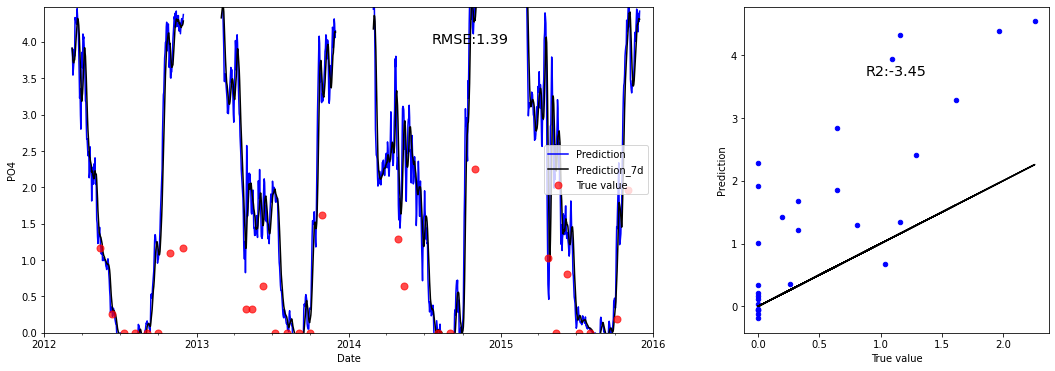

In [131]:
# predict nutreint 3
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 

features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [132]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,SST,delT,U,AirT,Prec,swr,MLD,W,Ice_d,days_from_iceoff,inflow,outflow,O2,N_Nit,PO4
0,1979-03-01,0.764389,-2.620929,1.593941,-2.992495,0.4762,185.210999,1.548121,0.000000,93.000000,-46,7.635921,7.867276,434.914856,36.579849,2.858155
1,1979-03-02,0.920434,-2.468256,4.249354,-5.280408,0.6036,188.470290,1.501116,0.000000,93.000000,-45,7.287510,7.936561,434.914856,36.579849,2.858155
2,1979-03-03,0.727219,-2.664457,3.202813,-1.517493,9.6772,75.183791,0.650000,0.000000,93.000000,-44,8.554949,8.209879,434.914856,36.579849,2.858155
3,1979-03-04,0.174805,-3.218732,1.919469,0.616671,3.0956,109.187751,0.650000,0.000000,93.000000,-43,9.942403,8.346746,434.914856,36.579849,2.858155
4,1979-03-05,0.084467,-3.311187,2.815478,-2.330826,0.0822,84.293958,0.650000,0.000000,93.000000,-42,9.816358,8.669169,434.914856,36.579849,2.858155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10170,2015-11-26,6.730435,0.778029,3.169159,4.285010,25.0532,25.239375,25.000000,0.000000,100.958333,223,16.804982,11.418577,337.377838,13.061831,4.135699
10171,2015-11-27,6.626987,0.000000,5.685337,2.327086,12.5068,66.596083,25.000000,0.000000,100.958333,224,15.235910,13.823858,338.115784,13.464437,4.300817
10172,2015-11-28,6.360925,1.181410,2.800493,-0.982494,0.0000,81.125292,23.150000,1.769155,100.958333,225,17.910961,14.750084,337.865784,13.367914,4.392172
10173,2015-11-29,6.137963,1.383737,1.984414,-1.319994,0.0000,42.381708,21.874141,2.731964,100.958333,226,18.948644,15.256056,337.856110,13.891962,4.277739


Nutrient: N_Amm
['delT', 'U', 'AirT', 'Prec', 'swr', 'MLD', 'W', 'Ice_d', 'days_from_iceoff', 'inflow', 'outflow', 'O2', 'N_Nit', 'PO4']
Delete features? (Y/N)Y
['delT', 'U', 'AirT', 'Prec', 'swr', 'MLD', 'W', 'Ice_d', 'days_from_iceoff', 'inflow', 'outflow', 'O2', 'N_Nit', 'PO4']
Location of the feature:-1
Delete features? (Y/N)N
Add features? (Y/N)N
(9075, 8, 13) (9075,) (1093, 8, 13) (1093,)
number of input timesteps: 8
number of features: 13
number of samples: 73
Test RMSE: 3.14
Test R2: 0.58
Training dataset RMSE 3.08 (+/- 1.02)
Training dataset R2 0.71 (+/- 0.18)
Model takes 4 min to run


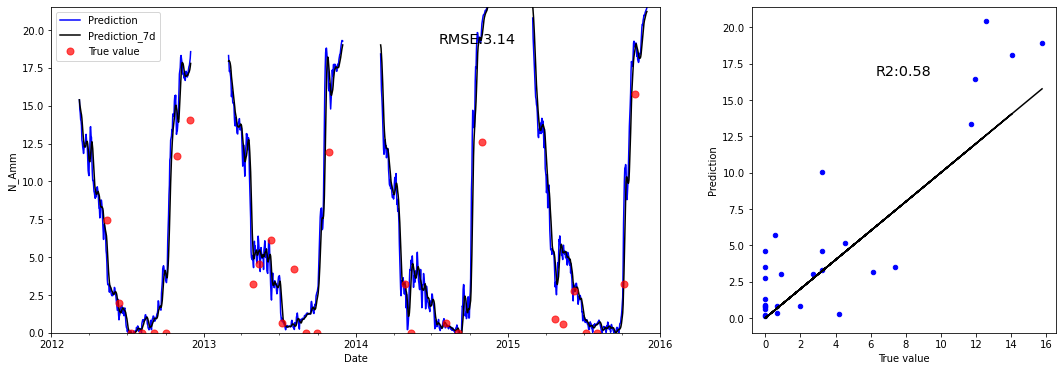

In [133]:
# predict nutreint 4
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 

features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [134]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,SST,delT,U,AirT,Prec,swr,MLD,W,Ice_d,days_from_iceoff,inflow,outflow,O2,N_Nit,PO4,N_Amm
0,1979-03-01,0.764389,-2.620929,1.593941,-2.992495,0.4762,185.210999,1.548121,0.000000,93.000000,-46,7.635921,7.867276,434.914856,36.579849,2.858155,13.903327
1,1979-03-02,0.920434,-2.468256,4.249354,-5.280408,0.6036,188.470290,1.501116,0.000000,93.000000,-45,7.287510,7.936561,434.914856,36.579849,2.858155,13.903327
2,1979-03-03,0.727219,-2.664457,3.202813,-1.517493,9.6772,75.183791,0.650000,0.000000,93.000000,-44,8.554949,8.209879,434.914856,36.579849,2.858155,13.903327
3,1979-03-04,0.174805,-3.218732,1.919469,0.616671,3.0956,109.187751,0.650000,0.000000,93.000000,-43,9.942403,8.346746,434.914856,36.579849,2.858155,13.903327
4,1979-03-05,0.084467,-3.311187,2.815478,-2.330826,0.0822,84.293958,0.650000,0.000000,93.000000,-42,9.816358,8.669169,434.914856,36.579849,2.858155,13.903327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10170,2015-11-26,6.730435,0.778029,3.169159,4.285010,25.0532,25.239375,25.000000,0.000000,100.958333,223,16.804982,11.418577,337.377838,13.061831,4.135699,21.169281
10171,2015-11-27,6.626987,0.000000,5.685337,2.327086,12.5068,66.596083,25.000000,0.000000,100.958333,224,15.235910,13.823858,338.115784,13.464437,4.300817,21.253782
10172,2015-11-28,6.360925,1.181410,2.800493,-0.982494,0.0000,81.125292,23.150000,1.769155,100.958333,225,17.910961,14.750084,337.865784,13.367914,4.392172,21.321959
10173,2015-11-29,6.137963,1.383737,1.984414,-1.319994,0.0000,42.381708,21.874141,2.731964,100.958333,226,18.948644,15.256056,337.856110,13.891962,4.277739,21.375145


Nutrient: Si
['delT', 'U', 'AirT', 'Prec', 'swr', 'MLD', 'W', 'Ice_d', 'days_from_iceoff', 'inflow', 'outflow', 'O2', 'N_Nit', 'N_Amm']
Delete features? (Y/N)N
Add features? (Y/N)N
(9075, 8, 14) (9075,) (1093, 8, 14) (1093,)
number of input timesteps: 8
number of features: 14
number of samples: 73
Test RMSE: 45.03
Test R2: -1.35
Training dataset RMSE 42.41 (+/- 9.06)
Training dataset R2 -0.12 (+/- 0.38)
Model takes 4 min to run


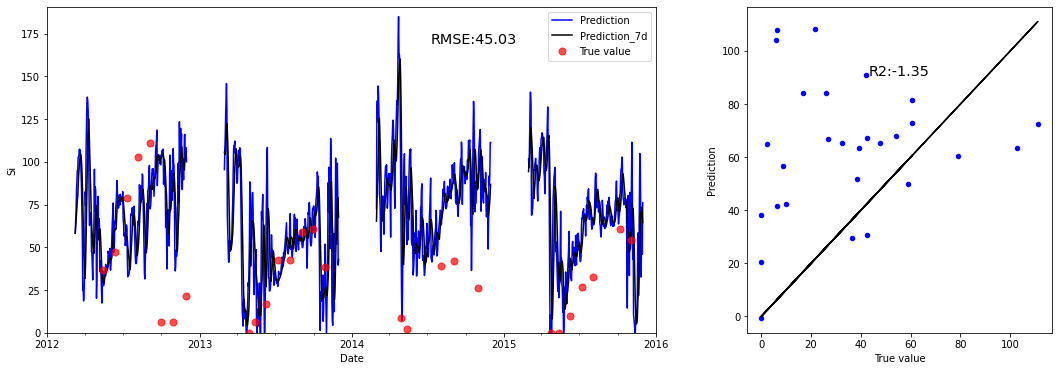

In [135]:
# predict nutreint 5
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 

features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [136]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,SST,delT,U,AirT,Prec,swr,MLD,W,Ice_d,days_from_iceoff,inflow,outflow,O2,N_Nit,PO4,N_Amm,Si
0,1979-03-01,0.764389,-2.620929,1.593941,-2.992495,0.4762,185.210999,1.548121,0.000000,93.000000,-46,7.635921,7.867276,434.914856,36.579849,2.858155,13.903327,43.765980
1,1979-03-02,0.920434,-2.468256,4.249354,-5.280408,0.6036,188.470290,1.501116,0.000000,93.000000,-45,7.287510,7.936561,434.914856,36.579849,2.858155,13.903327,43.765980
2,1979-03-03,0.727219,-2.664457,3.202813,-1.517493,9.6772,75.183791,0.650000,0.000000,93.000000,-44,8.554949,8.209879,434.914856,36.579849,2.858155,13.903327,43.765980
3,1979-03-04,0.174805,-3.218732,1.919469,0.616671,3.0956,109.187751,0.650000,0.000000,93.000000,-43,9.942403,8.346746,434.914856,36.579849,2.858155,13.903327,43.765980
4,1979-03-05,0.084467,-3.311187,2.815478,-2.330826,0.0822,84.293958,0.650000,0.000000,93.000000,-42,9.816358,8.669169,434.914856,36.579849,2.858155,13.903327,43.765980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10170,2015-11-26,6.730435,0.778029,3.169159,4.285010,25.0532,25.239375,25.000000,0.000000,100.958333,223,16.804982,11.418577,337.377838,13.061831,4.135699,21.169281,32.546326
10171,2015-11-27,6.626987,0.000000,5.685337,2.327086,12.5068,66.596083,25.000000,0.000000,100.958333,224,15.235910,13.823858,338.115784,13.464437,4.300817,21.253782,47.237068
10172,2015-11-28,6.360925,1.181410,2.800493,-0.982494,0.0000,81.125292,23.150000,1.769155,100.958333,225,17.910961,14.750084,337.865784,13.367914,4.392172,21.321959,70.303116
10173,2015-11-29,6.137963,1.383737,1.984414,-1.319994,0.0000,42.381708,21.874141,2.731964,100.958333,226,18.948644,15.256056,337.856110,13.891962,4.277739,21.375145,45.928936


Nutrient: CAR_dic
['delT', 'U', 'AirT', 'Prec', 'swr', 'MLD', 'W', 'Ice_d', 'days_from_iceoff', 'inflow', 'outflow', 'O2', 'N_Nit', 'N_Amm', 'Si']
Delete features? (Y/N)N
Add features? (Y/N)N
(9075, 8, 15) (9075,) (1093, 8, 15) (1093,)
number of input timesteps: 8
number of features: 15
number of samples: 73
Test RMSE: 528.36
Test R2: 0.15
Training dataset RMSE 479.34 (+/- 216.24)
Training dataset R2 -0.16 (+/- 0.31)
Model takes 4 min to run


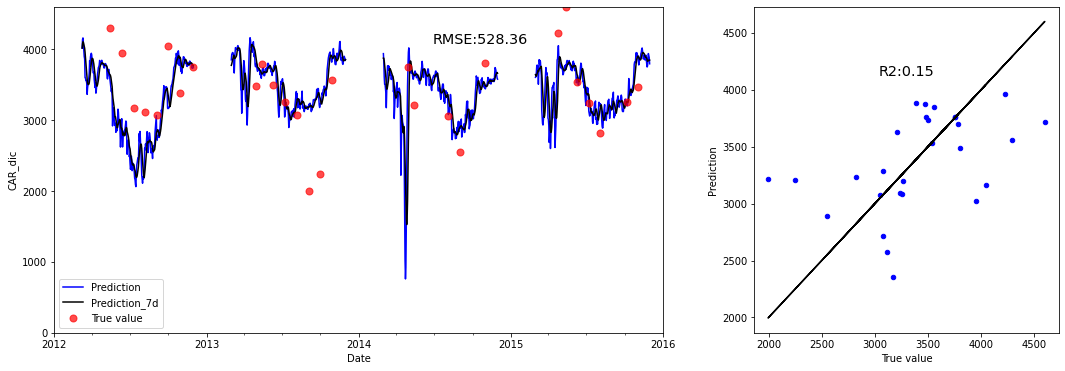

In [137]:
# predict nutreint 6
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 

features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [138]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,SST,delT,U,AirT,Prec,swr,MLD,W,Ice_d,days_from_iceoff,inflow,outflow,O2,N_Nit,PO4,N_Amm,Si,CAR_dic
0,1979-03-01,0.764389,-2.620929,1.593941,-2.992495,0.4762,185.210999,1.548121,0.000000,93.000000,-46,7.635921,7.867276,434.914856,36.579849,2.858155,13.903327,43.765980,3901.149658
1,1979-03-02,0.920434,-2.468256,4.249354,-5.280408,0.6036,188.470290,1.501116,0.000000,93.000000,-45,7.287510,7.936561,434.914856,36.579849,2.858155,13.903327,43.765980,3901.149658
2,1979-03-03,0.727219,-2.664457,3.202813,-1.517493,9.6772,75.183791,0.650000,0.000000,93.000000,-44,8.554949,8.209879,434.914856,36.579849,2.858155,13.903327,43.765980,3901.149658
3,1979-03-04,0.174805,-3.218732,1.919469,0.616671,3.0956,109.187751,0.650000,0.000000,93.000000,-43,9.942403,8.346746,434.914856,36.579849,2.858155,13.903327,43.765980,3901.149658
4,1979-03-05,0.084467,-3.311187,2.815478,-2.330826,0.0822,84.293958,0.650000,0.000000,93.000000,-42,9.816358,8.669169,434.914856,36.579849,2.858155,13.903327,43.765980,3901.149658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10170,2015-11-26,6.730435,0.778029,3.169159,4.285010,25.0532,25.239375,25.000000,0.000000,100.958333,223,16.804982,11.418577,337.377838,13.061831,4.135699,21.169281,32.546326,3886.783691
10171,2015-11-27,6.626987,0.000000,5.685337,2.327086,12.5068,66.596083,25.000000,0.000000,100.958333,224,15.235910,13.823858,338.115784,13.464437,4.300817,21.253782,47.237068,3938.664551
10172,2015-11-28,6.360925,1.181410,2.800493,-0.982494,0.0000,81.125292,23.150000,1.769155,100.958333,225,17.910961,14.750084,337.865784,13.367914,4.392172,21.321959,70.303116,3907.656494
10173,2015-11-29,6.137963,1.383737,1.984414,-1.319994,0.0000,42.381708,21.874141,2.731964,100.958333,226,18.948644,15.256056,337.856110,13.891962,4.277739,21.375145,45.928936,3882.826660


Nutrient: TOTN
['AirP', 'AirT', 'RelHum', 'SWR', 'Prec', 'CC', 'U', 'delT', 'inflow(m3/s)', 'outflow(m3/s)', 'Ice_d', 'days from iceoff', 'W', 'MLD', 'thermD', 'NO3N', 'O2', 'PO4P', 'TOC', 'SiO2']
Delete features? (Y/N)N
Add features? (Y/N)N
(5225, 8, 20) (5225,) (818, 8, 20) (818,)
number of input timesteps: 8
number of features: 20
number of samples: 195
Test RMSE: 204.11
Test R2: 0.02
Training dataset RMSE 128.19 (+/- 14.39)
Training dataset R2 0.66 (+/- 0.07)
Model takes 6 min to run


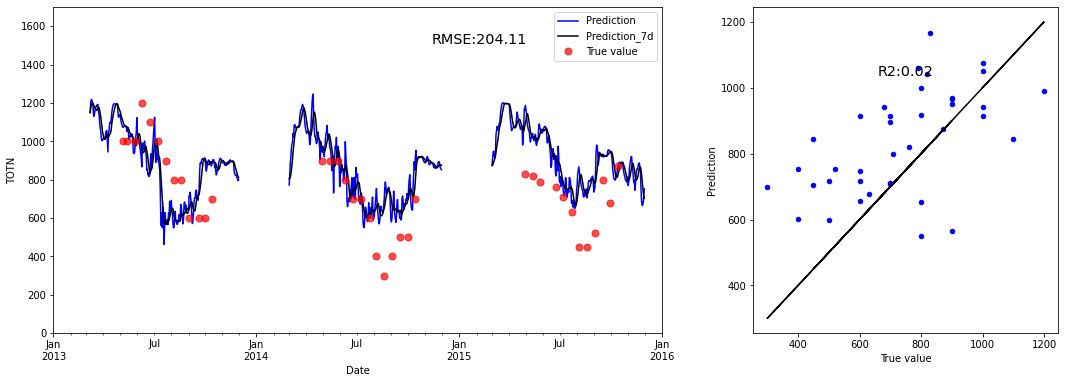

In [59]:
# predict nutreint 7
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 

features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [60]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,AirP,AirT,RelHum,SWR,Prec,CC,U,delT,inflow(m3/s),outflow(m3/s),Ice_d,days from iceoff,W,MLD,thermD,NO3N,NH4N,O2,PO4P,TOC,SiO2,TOTN
0,1994-03-01,1018.4190,-9.955431,70.289411,55.50429,0.830272,0.458692,3.483176,0.256206,1.334310,0.618518,149,-54.0,2.724398,19.0000,19.0000,748.871216,9.498289,12.831825,11.832375,7.776436,4.142416,1193.477173
1,1994-03-02,1012.0800,-8.835930,81.223724,54.56624,1.530000,0.854867,3.226721,0.256183,1.319589,0.606296,149,-53.0,2.191399,19.0000,19.0000,748.871216,9.498289,12.831825,11.832375,7.776436,4.142416,1193.477173
2,1994-03-03,1002.8600,-4.911451,88.727730,107.72920,0.423039,0.993754,1.846146,0.256237,1.305278,0.594445,149,-52.0,4.483183,19.0000,19.0000,748.871216,9.498289,12.831825,11.832375,7.776436,4.142416,1193.477173
3,1994-03-04,1005.3750,-2.776745,91.194580,134.25160,0.000784,0.708459,0.842008,0.256201,1.289619,0.582592,149,-51.0,254.546565,19.0000,19.0000,748.871216,9.498289,12.831825,11.832375,7.776436,4.142416,1193.477173
4,1994-03-05,997.0792,2.236131,92.617668,80.39046,0.338688,1.000008,7.107113,0.256180,5.335259,2.310000,149,-50.0,0.000000,19.0000,19.0000,748.871216,9.498289,12.831825,11.832375,7.776436,4.142416,1193.477173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6045,2015-11-26,994.5456,0.139770,93.686831,20.64251,0.000000,0.548573,2.173018,2.130598,13.161086,5.502222,81,258.0,20.616081,10.6501,10.6501,21.003368,31.282879,9.494571,6.466239,8.121214,1.742163,665.334106
6046,2015-11-27,985.3168,9.021081,90.547242,21.62850,0.001345,0.968004,6.680271,1.606879,12.064328,4.874074,81,259.0,3.705116,11.0968,11.0968,30.501335,34.556225,10.115715,5.661668,7.792230,2.293807,668.251038
6047,2015-11-28,978.9278,4.759586,86.624472,21.59980,0.003703,0.634158,4.535557,0.004524,21.783314,5.718518,81,260.0,0.032103,19.0000,19.0000,48.009514,41.300682,9.916005,6.195094,7.691663,2.616372,681.385437
6048,2015-11-29,969.5997,3.935289,87.554448,20.77313,0.000335,0.928686,4.846388,0.003058,29.578538,7.736296,81,261.0,0.049188,19.0000,19.0000,88.986794,44.988178,9.411903,5.799950,7.743204,3.051733,721.415222


Nutrient: Chl
['SST', 'delT', 'U', 'AirT', 'Prec', 'swr', 'MLD', 'W', 'Ice_d', 'days_from_iceoff', 'inflow', 'outflow', 'O2', 'N_Nit', 'N_Amm', 'CAR_dic']
Delete features? (Y/N)N
Add features? (Y/N)N
(9143, 8, 16) (9143,) (1120, 8, 16) (1120,)
number of input timesteps: 8
number of features: 16
number of samples: 141
Test RMSE: 10.10
Test R2: -0.38
Training dataset RMSE 6.80 (+/- 1.64)
Training dataset R2 0.16 (+/- 0.15)
Model takes 8 min to run


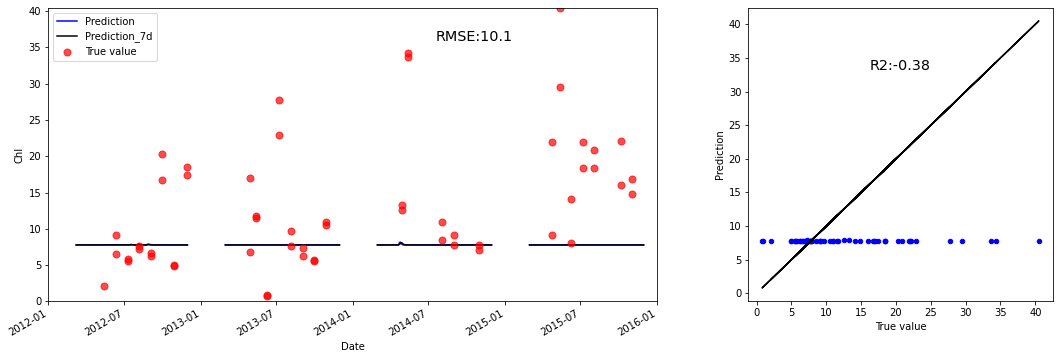

In [104]:
# predict nutreint 8
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 

features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [62]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,AirP,AirT,RelHum,SWR,Prec,CC,U,delT,inflow(m3/s),outflow(m3/s),Ice_d,days from iceoff,W,MLD,thermD,NO3N,NH4N,O2,PO4P,TOC,SiO2,TOTN,TOTP
0,1994-03-01,1018.4190,-9.955431,70.289411,55.50429,0.830272,0.458692,3.483176,0.256206,1.334310,0.618518,149,-54.0,2.724398,19.0000,19.0000,748.871216,9.498289,12.831825,11.832375,7.776436,4.142416,1193.477173,29.339554
1,1994-03-02,1012.0800,-8.835930,81.223724,54.56624,1.530000,0.854867,3.226721,0.256183,1.319589,0.606296,149,-53.0,2.191399,19.0000,19.0000,748.871216,9.498289,12.831825,11.832375,7.776436,4.142416,1193.477173,29.339554
2,1994-03-03,1002.8600,-4.911451,88.727730,107.72920,0.423039,0.993754,1.846146,0.256237,1.305278,0.594445,149,-52.0,4.483183,19.0000,19.0000,748.871216,9.498289,12.831825,11.832375,7.776436,4.142416,1193.477173,29.339554
3,1994-03-04,1005.3750,-2.776745,91.194580,134.25160,0.000784,0.708459,0.842008,0.256201,1.289619,0.582592,149,-51.0,254.546565,19.0000,19.0000,748.871216,9.498289,12.831825,11.832375,7.776436,4.142416,1193.477173,29.339554
4,1994-03-05,997.0792,2.236131,92.617668,80.39046,0.338688,1.000008,7.107113,0.256180,5.335259,2.310000,149,-50.0,0.000000,19.0000,19.0000,748.871216,9.498289,12.831825,11.832375,7.776436,4.142416,1193.477173,29.339554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6045,2015-11-26,994.5456,0.139770,93.686831,20.64251,0.000000,0.548573,2.173018,2.130598,13.161086,5.502222,81,258.0,20.616081,10.6501,10.6501,21.003368,31.282879,9.494571,6.466239,8.121214,1.742163,665.334106,29.505936
6046,2015-11-27,985.3168,9.021081,90.547242,21.62850,0.001345,0.968004,6.680271,1.606879,12.064328,4.874074,81,259.0,3.705116,11.0968,11.0968,30.501335,34.556225,10.115715,5.661668,7.792230,2.293807,668.251038,28.986773
6047,2015-11-28,978.9278,4.759586,86.624472,21.59980,0.003703,0.634158,4.535557,0.004524,21.783314,5.718518,81,260.0,0.032103,19.0000,19.0000,48.009514,41.300682,9.916005,6.195094,7.691663,2.616372,681.385437,28.893240
6048,2015-11-29,969.5997,3.935289,87.554448,20.77313,0.000335,0.928686,4.846388,0.003058,29.578538,7.736296,81,261.0,0.049188,19.0000,19.0000,88.986794,44.988178,9.411903,5.799950,7.743204,3.051733,721.415222,29.062391


Nutrient: Chl
['delT', 'U', 'AirT', 'Prec', 'swr', 'MLD', 'W', 'Ice_d', 'days_from_iceoff', 'inflow', 'outflow', 'O2', 'N_Nit', 'N_Amm', 'Si', 'CAR_dic', 'PO4', 'Chl']
Delete features? (Y/N)Y
['delT', 'U', 'AirT', 'Prec', 'swr', 'MLD', 'W', 'Ice_d', 'days_from_iceoff', 'inflow', 'outflow', 'O2', 'N_Nit', 'N_Amm', 'Si', 'CAR_dic', 'PO4', 'Chl']
Location of the feature:-1
Delete features? (Y/N)Y
['delT', 'U', 'AirT', 'Prec', 'swr', 'MLD', 'W', 'Ice_d', 'days_from_iceoff', 'inflow', 'outflow', 'O2', 'N_Nit', 'N_Amm', 'Si', 'CAR_dic', 'PO4']
Location of the feature:-1
Delete features? (Y/N)N
Add features? (Y/N)N
(9281, 8, 16) (9281,) (1174, 8, 16) (1174,)
number of input timesteps: 8
number of features: 16
number of samples: 279
Test RMSE: 9.99
Test R2: -0.36
Training dataset RMSE 6.92 (+/- 0.91)
Training dataset R2 0.13 (+/- 0.19)
Model takes 13 min to run


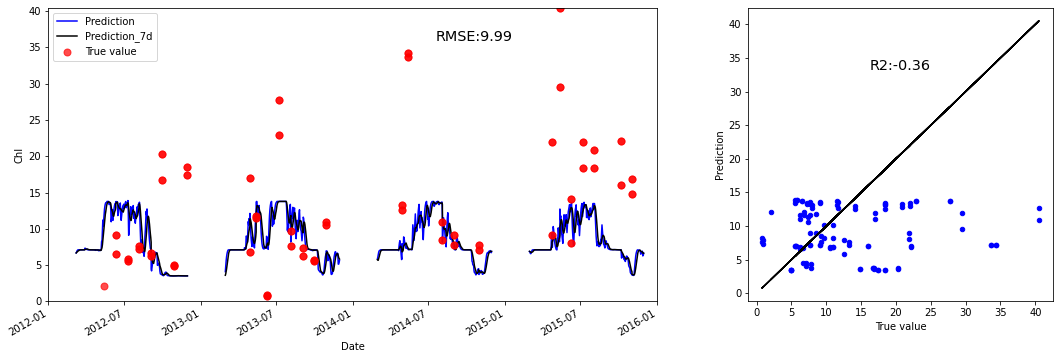

In [143]:
# predict Chl
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 

features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [144]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,SST,delT,U,AirT,Prec,swr,MLD,W,Ice_d,days_from_iceoff,inflow,outflow,O2,N_Nit,PO4,N_Amm,Si,CAR_dic,Chl
0,1979-03-01,0.764389,-2.620929,1.593941,-2.992495,0.4762,185.210999,1.548121,0.000000,93.000000,-46,7.635921,7.867276,434.914856,36.579849,2.858155,13.903327,43.765980,3901.149658,7.097477
1,1979-03-02,0.920434,-2.468256,4.249354,-5.280408,0.6036,188.470290,1.501116,0.000000,93.000000,-45,7.287510,7.936561,434.914856,36.579849,2.858155,13.903327,43.765980,3901.149658,7.097477
2,1979-03-03,0.727219,-2.664457,3.202813,-1.517493,9.6772,75.183791,0.650000,0.000000,93.000000,-44,8.554949,8.209879,434.914856,36.579849,2.858155,13.903327,43.765980,3901.149658,7.097477
3,1979-03-04,0.174805,-3.218732,1.919469,0.616671,3.0956,109.187751,0.650000,0.000000,93.000000,-43,9.942403,8.346746,434.914856,36.579849,2.858155,13.903327,43.765980,3901.149658,7.097477
4,1979-03-05,0.084467,-3.311187,2.815478,-2.330826,0.0822,84.293958,0.650000,0.000000,93.000000,-42,9.816358,8.669169,434.914856,36.579849,2.858155,13.903327,43.765980,3901.149658,7.097477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10457,2015-11-26,6.730435,0.778029,3.169159,4.285010,25.0532,25.239375,25.000000,0.000000,100.958333,223,16.804982,11.418577,337.377838,13.061831,4.135699,21.169281,32.546326,3886.783691,6.883196
10458,2015-11-27,6.626987,0.000000,5.685337,2.327086,12.5068,66.596083,25.000000,0.000000,100.958333,224,15.235910,13.823858,338.115784,13.464437,4.300817,21.253782,47.237068,3938.664551,6.914966
10459,2015-11-28,6.360925,1.181410,2.800493,-0.982494,0.0000,81.125292,23.150000,1.769155,100.958333,225,17.910961,14.750084,337.865784,13.367914,4.392172,21.321959,70.303116,3907.656494,6.262680
10460,2015-11-29,6.137963,1.383737,1.984414,-1.319994,0.0000,42.381708,21.874141,2.731964,100.958333,226,18.948644,15.256056,337.856110,13.891962,4.277739,21.375145,45.928936,3882.826660,6.336897


In [145]:
Nut_memory.to_csv(lakename+'_LSTM predicted nutrient and Chl data.csv',sep='\t',index=False)